In [1]:
import netket as nk
import netket.experimental as nkx
import netket.nn as nknn
import jax.numpy as jnp
from jax import grad, vmap
import jax
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from netket.operator.spin import sigmax,sigmaz 
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 28})

from netket.utils.types import NNInitFunc
from typing import Union, Any
from scipy.sparse.linalg import spsolve
import scipy.sparse
from matplotlib import collections as matcoll
import time


# Parameters

In [2]:
N = 8                   # number of spins
Ns = 512                # number of samples
N_discard = 128         # how many samples to discard to reach termalization
dt = 5e-2               # time discretization interval
alpha = 4
M = alpha*N

# Hamiltonian

In [3]:
hi = nk.hilbert.Spin(s=1 / 2, N=N)

g = nk.graph.Hypercube(length=N, n_dim=1, pbc=True)
Gamma = -1
H_op = sum([Gamma*sigmax(hi,i) for i in range(N)])

V= -1
H_op += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

H = H_op.to_dense()
H_sparse = H_op.to_sparse()


# Complex RBM

In [4]:

default_kernel_init = jax.nn.initializers.normal(stddev=0.01, dtype='complex')

class ComplexRBM(nn.Module):
    """A restricted boltzman Machine, equivalent to a 2-layer FFNN with a
    nonlinear activation function in between.
    """

    dtype: Any = np.complex128
    """The dtype of the weights."""
    activation: Any = nknn.log_cosh
    """The nonlinear activation function."""
    alpha: Union[float, int] = 1
    """feature density. Number of features equal to alpha * input.shape[-1]"""
    use_hidden_bias: bool = True
    """if True uses a bias in the dense layer (hidden layer bias)."""
    use_visible_bias: bool = True
    """if True adds a bias to the input not passed through the nonlinear layer."""
    precision: Any = None
    """numerical precision of the computation see `jax.lax.Precision`for details."""


    kernel_init: NNInitFunc = default_kernel_init
    """Initializer for the Dense layer matrix."""
    hidden_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the hidden bias."""
    visible_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the visible bias."""

    @nn.compact
    def __call__(self, input):
        x = nknn.Dense(
            name="Dense",
            features=int(self.alpha * input.shape[-1]),
            dtype=self.dtype,
            precision=self.precision,
            use_bias=self.use_hidden_bias,
            kernel_init=self.kernel_init,
            bias_init=self.hidden_bias_init,
        )(input)
        x = self.activation(x)
        x = jnp.sum(x, axis=-1)

        if self.use_visible_bias:
            v_bias = self.param(
                "visible_bias", self.visible_bias_init, (input.shape[-1],), self.dtype
            )
            out_bias = jnp.dot(input, v_bias)
            return x + out_bias
        else:
            return x


# Model

In [5]:
def netket_model(p, Ns = 1008):
  if(2*(N+M+M*N) != p.size): 
    print("Invalid number of weights!")
  p1 = p[:int(p.size/2)]                                                  
  p2 = p[int(p.size/2):]                                                   
  a = p1[0 : N] + 1j*p2[0 : N]
  b = p1[N : N + M] + 1j*p2[N : N + M]
  W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

  nkmodel = ComplexRBM(alpha=alpha)
  nksampler = nk.sampler.MetropolisLocal(hilbert=hi)
  nkvstate = nk.vqs.MCState(nksampler, nkmodel, n_samples=Ns)
  nkvstate.parameters = {'Dense': {'bias': b, 'kernel': W}, 'visible_bias': a}
  return nkvstate

@jax.jit
def logpsi(p, x):
    p1 = p[:int(p.size/2)]                                                   # the log wave function on them. If it does not receive samples, it computes
    p2 = p[int(p.size/2):]                                                   # the log wave function on the whole Hilbert space.
    a = p1[0 : N] + 1j*p2[0 : N]
    b = p1[N : N + M] + 1j*p2[N : N + M]
    W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

    out = lambda a_, b_, W_, x_: jnp.dot(a_, x_) + jnp.sum(nknn.log_cosh(b_ + jnp.dot(W_.T, x_)))
    return vmap(out, in_axes = [None, None, None, 0])(a, b, W, x)   

@jax.jit
def logpsi_re(p, x):                                        # It computes the real part of the log wave function on a single sample  
  p1 = p[:int(p.size/2)]                                                   # (not vectorized with vmap). It serves to compute the gradient of the log 
  p2 = p[int(p.size/2):]                                                   # wave function since jax.grad operates only on complex valued functions if the 
  a = p1[0 : N] + 1j*p2[0 : N]                                        # parameters are complex, but in our case the parameters are real
  b = p1[N : N + M] + 1j*p2[N : N + M]
  W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

  output = jnp.dot(a, x) + jnp.sum(nknn.log_cosh(b + jnp.dot(W.T, x)))
  return output.real

@jax.jit
def logpsi_imag(p, x):                                        # It computes the real part of the log wave function on a single sample  
  p1 = p[:int(p.size/2)]                                                   # (not vectorized with vmap). It serves to compute the gradient of the log 
  p2 = p[int(p.size/2):]                                                   # wave function since jax.grad operates only on complex valued functions if the 
  a = p1[0 : N] + 1j*p2[0 : N]                                        # parameters are complex, but in our case the parameters are real
  b = p1[N : N + M] + 1j*p2[N : N + M]
  W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

  output = jnp.dot(a, x) + jnp.sum(nknn.log_cosh(b + jnp.dot(W.T, x)))
  return output.imag

@jax.jit
def grad_logpsi(p, x):
  grad_wf = vmap(grad(logpsi_re, argnums=0), in_axes = [None, 0])(p, x) + 1j*vmap(grad(logpsi_imag, argnums = 0), in_axes = [None, 0])(p, x)
  return grad_wf


## Sampling

In [6]:
def nksampling(Ns, p):                                                                         
    samples = netket_model(p).sample(n_samples = Ns)                                                # It samples from the internal netket variational state.
    return np.reshape(samples, (samples.shape[0]*samples.shape[1], samples.shape[2]))

def single_spin_flip(x):
  N = len(x)                                                                                   # It implements the single spin flip updating rule.
  x = x.copy()

  idx = np.random.choice(np.arange(N))
  x[idx] = -x[idx]

  return x

def sample_step(p, x, logpsi_x, propose_fn, eps = 0):                                                                                                                                        # It realizes the Metropolis step.
    if logpsi_x is None:
        logpsi_x = logpsi(p, np.expand_dims(x, 0))[0]
  
    x_proposed = propose_fn(x) 

    logpsi_x_proposed = logpsi(p, np.expand_dims(x_proposed, 0))[0]

    if(eps == 0):
      r = jnp.abs(jnp.exp(logpsi_x_proposed - logpsi_x))**2
    else: 
      r = (jnp.abs(jnp.exp(logpsi_x_proposed))**2 + eps**2) / (jnp.abs(jnp.exp(logpsi_x))**2 + eps**2)
    xi = np.random.uniform()
    accept = xi < r

    if accept:
        return x_proposed, logpsi_x_proposed
    else:
        return x, logpsi_x

def sample_mcmc(p, Ns, N_discard, x0=None, eps = 0):                                             # It realizes the mcmc sampling (possible with smearing eps)
    if x0 is None:
        x0 = np.random.choice(np.array([-1,1]), size=(1, N))[0]

    x = x0
    logpsi_x = None
    propose_fn = single_spin_flip
    
    for i in range(N_discard):
        x, logpsi_x = sample_step(p, x, logpsi_x, propose_fn, eps = eps)

    samples = []
    for i in range(Ns):
        x, logpsi_x = sample_step(p, x, logpsi_x, propose_fn, eps = eps)
        samples.append(x)

    return jnp.vstack(samples)


def generate_pool_of_samples(p, n_iter_max = 200, n_samples_per_iter = 1008, rescaling_factor = 10, eps = 0, method = "netket"):
  n_samples_tot = int(n_iter_max * n_samples_per_iter / rescaling_factor)
  if(method == "netket"):
    pool_of_samples =  nksampling(n_samples_tot, p)
  if(method == "diy"): 
    pool_of_samples = sample_mcmc(p, n_samples_tot, N_discard = 500, eps = eps)
  
  assert pool_of_samples.shape == (n_samples_tot, N)
  return pool_of_samples

# Local kernels

In [7]:
H_ising = nk.operator.Ising(hi, g, h = 1, J = -1)


In [8]:
@jax.jit
def x_H_psi(p, x_prime, mels):
    logpsi_x_prime = logpsi(p, x_prime.reshape(-1, N)).reshape(x_prime.shape[:-1])
    local_estimator = (mels * jnp.exp(logpsi_x_prime)).sum(axis=-1)
    return local_estimator

@jax.jit
def x_HDk_psi(p, x_prime, mels):                                                                                         
    logpsi_x_prime = logpsi(p, x_prime.reshape(-1, N)).reshape(x_prime.shape[:-1])
    grad_logpsi_x_prime = grad_logpsi(p, x_prime.reshape(-1, N)).reshape(x_prime.shape[0], x_prime.shape[1], p.size)
    local_estimator = jnp.einsum('ij, ijk, ij -> ik', mels, grad_logpsi_x_prime, jnp.exp(logpsi_x_prime))
    return local_estimator

@jax.jit
def estimate_E(p, x, x_prime, mels):
    mel = x_H_psi(p, x_prime, mels)                                                                      # It computes the mean energy
    E = (mel/jnp.exp(logpsi(p,x))).mean()
    return E

# Losses

In [9]:
######################################## ESTIMATE L2 PSI ########################################
def estimate_L2_psi(p, p_prime, x, x_prime, mels, dt, eps = 0):
  psi, loss_local, grad_local = estimate_L2_psi_internal_jitted(p, p_prime, x, x_prime, mels, dt)

  if(eps == 0):
    loss_local /= jnp.square(jnp.absolute(psi)) 
    grad_local = jnp.einsum('ij, i -> ij', grad_local, jnp.square(jnp.absolute(psi))**(-1))

  else:
    P = jnp.absolute(jnp.square(psi)) + eps**2 
    loss_local /= P
    grad_local = np.einsum('ij, i -> ij', grad_local, P**(-1))

  return loss_local.mean(), grad_local.mean(axis = 0)

@jax.jit
def estimate_L2_psi_internal_jitted(p, p_prime, x, x_prime, mels, dt): 
  psi = jnp.exp(logpsi(p, x)) 
  psi_prime = jnp.exp(logpsi(p_prime, x))

  one = psi - 0.5j * dt * x_H_psi(p, x_prime, mels) 
  two = psi_prime + 0.5j * dt * x_H_psi(p_prime, x_prime, mels) 
        
  grad_psi_prime = jnp.einsum('ij, i -> ij', grad_logpsi(p_prime, x), psi_prime)
  grad_two = grad_psi_prime + 0.5j * dt * x_HDk_psi(p_prime, x_prime, mels)
  
  loss_local = jnp.square(jnp.absolute(one - two))
  grad_local = jnp.einsum('ij, i -> ij', grad_two, two.conj() - one.conj()) + jnp.einsum('ij, i -> ij', grad_two.conj(), two - one) 
  
  return psi, loss_local, grad_local

In [10]:
@jax.jit
def fidelity(p, p_prime, dt, H):                                                              
  psi_prime = jnp.exp(logpsi(p_prime, hi.all_states()))                                                             
  psi = jnp.exp(logpsi(p, hi.all_states()))                                                                    
  one = psi - (0.5j*dt) * H @ psi                                                               
  two = psi_prime + (0.5j*dt) * H @ psi_prime

  return -(jnp.abs(jnp.dot(one.conj(), two))**2)/((jnp.linalg.norm(one)**2)*(jnp.linalg.norm(two)**2))


# Adam optimization

In [11]:

################################## ADAM ##################################
def optimize_Adam(p, p_prime, loss, dt, H, lr=0.01, tol = 1e-5, n_iter_max = 500, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = jnp.array([]), eps = 0):
  loss_values = []
  fidelity_values = []

  lr_alarm = False

  m = np.zeros(p_prime.size)
  v = np.zeros(p_prime.size)

  t = 0
  while(1):

    if(pool_of_samples.shape[-1] == 0 or Ns == 0):
      print("Error: no samples!")

    idxs = np.random.choice(np.arange(pool_of_samples.shape[0]), size = Ns)
    x = pool_of_samples[idxs]
    x_prime, mels = H_ising.get_conn_padded(x)

    loss_value, loss_grad = estimate_L2_psi(p, p_prime, x, x_prime, mels, dt, eps = eps)

    fidelity_value = fidelity(p, p_prime, dt, H)

    loss_values.append(loss_value)
    fidelity_values.append(fidelity_value)

    if((1-np.abs(fidelity_values[-1])) < tol or t == n_iter_max): 
      print("Number of iteration to converge: ", t)
      break

    m = beta1*m + (1.-beta1)*loss_grad
    v = beta2*v + (1.-beta2)*loss_grad**2

    m_corr = m/(1.-beta1**(t+1))
    v_corr = v/(1.-beta2**(t+1))

    p_prime = p_prime - lr*(m_corr/(np.sqrt(v_corr)+epsilon))

    if(t%50 == 0): 
      print("Iteration number: ", t)
    
    #if(np.abs(fidelity_values[-1])<0.8):
    #  print("Too large learning rate")
    #  lr_alarm = True
    #  break
    t+=1

  return t, p_prime, loss_values, fidelity_values, lr_alarm

In [12]:
@jax.jit
def fidelity_(wf1, wf2):      ### is minus the fidelity  
  return -(jnp.abs(wf1.conj().T @ wf2)**2)/((jnp.linalg.norm(wf1)**2)*(jnp.linalg.norm(wf2)**2))


# Quenching

In [13]:
xcorr = sum([sigmax(hi,i) for i in range(N)])/N
zzcorr = sum([sigmaz(hi,i)*sigmaz(hi, (i+1)%N) for i in range(N)])/N


## Initial parameters

In [14]:
N = 8

hi = nk.hilbert.Spin(s=1 / 2, N=N)
Gamma = -0.5
H_op_aux = sum([Gamma*sigmax(hi,i) for i in range(N)])

V= -1
H_op_aux += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])
H_aux_sparse = H_op_aux.to_sparse()

eig_vals, eig_vecs = eigsh(H_aux_sparse, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-8.50908224 -8.50762639]


In [ ]:
# RBM ansatz with alpha=4
ma = nk.models.RBM(alpha=alpha)

# Build the sampler
sa = nk.sampler.MetropolisLocal(hilbert=hi)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1)

# The variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008)

# The ground-state optimization loop
gs = nk.VMC(
    hamiltonian=H_op_aux,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)
log=nk.logging.RuntimeLog()

start = time.time()
gs.run(out=log, n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',vs.n_parameters,'parameters')
print('The RBM calculation took',end-start,'seconds')

data_rbm = log.data

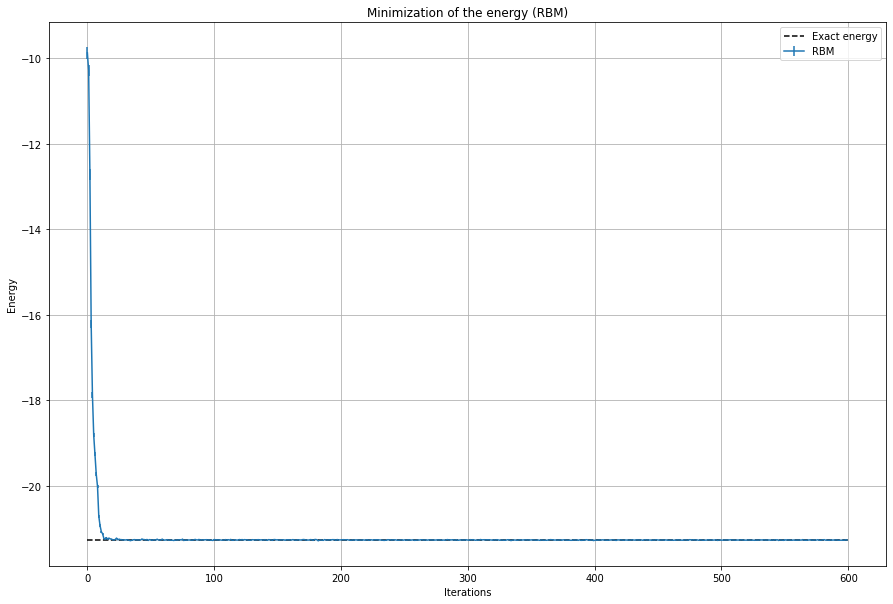

In [5]:
fig = plt.figure()
fig.set_size_inches(15, 10)
plt.errorbar(data_rbm["Energy"].iters, data_rbm["Energy"].Mean, yerr=data_rbm["Energy"].Sigma, label = "RBM")
plt.hlines(E_gs, 0, 600, colors = 'black', linestyle = 'dashed', label = 'Exact energy')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.title("Minimization of the energy (RBM)")
plt.legend()
plt.grid()
plt.show()

The minimum of this state is:  9.601962070489486e-09


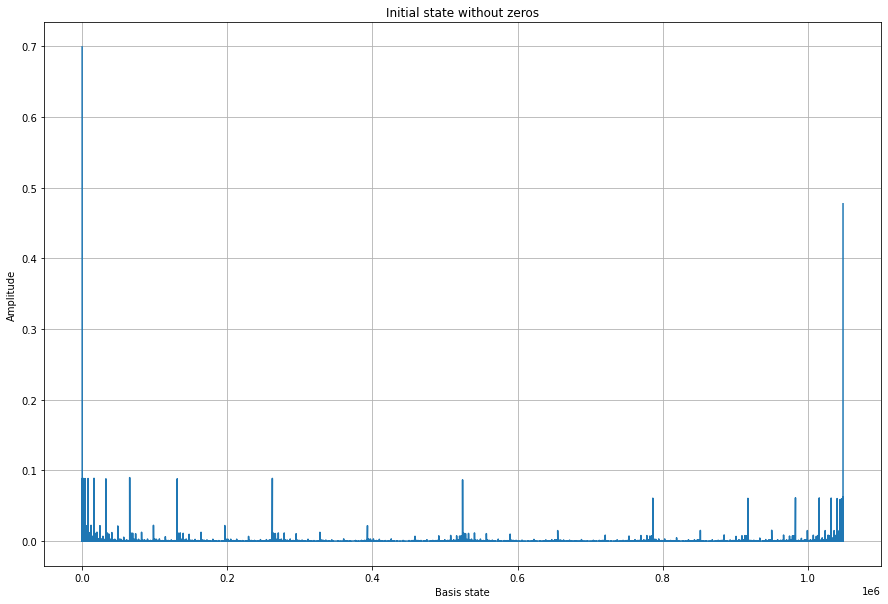

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.plot(vs.to_array())
ax.set_title("Initial state without zeros")
ax.set_xlabel("Basis state")
ax.set_ylabel("Amplitude")
ax.grid()

print("The minimum of this state is: ", jnp.min(vs.to_array()))

/home/sinibandro/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


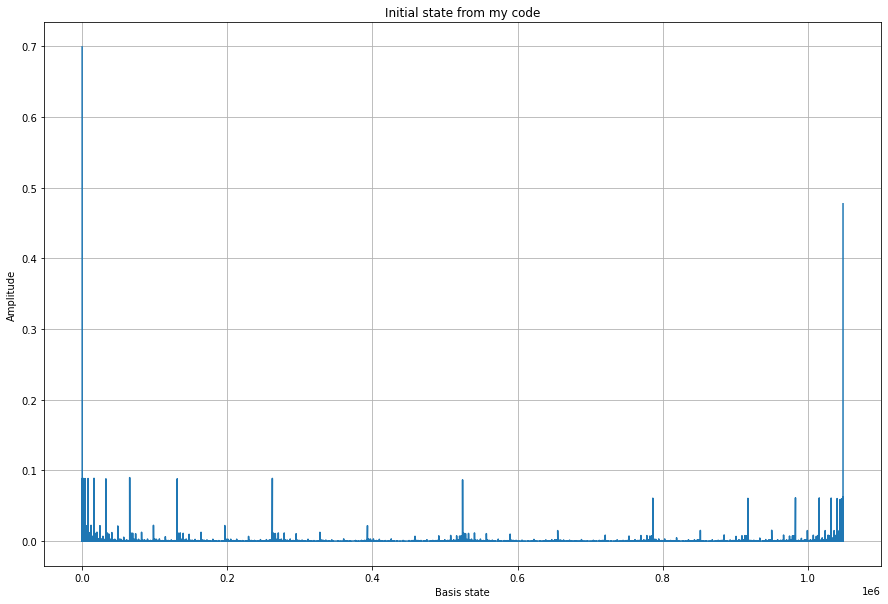

In [9]:
alpha = 4
M = alpha*N

hidden_bias = vs.parameters["Dense"]["bias"]
kernel = vs.parameters["Dense"]["kernel"]
visible_bias = vs.parameters["visible_bias"]

p_initial = np.concatenate((visible_bias.flatten(), hidden_bias.flatten(),  
                            kernel.flatten(), np.zeros(N+M+M*N)))

state = jnp.exp(logpsi(p_initial, hi.all_states()))
state = state/np.linalg.norm(state)


fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(state)
ax.set_title("Initial state from my code")
ax.set_xlabel("Basis state")
ax.set_ylabel("Amplitude")
ax.grid()


In [10]:
np.savetxt("p_initial_20_spins_alpha1.txt", p_initial)

In [14]:
p_initial = np.loadtxt("p_initial.txt")

## Exact evolution

In [15]:
@jax.jit
def exact_evolution(wf_norm, dt, H):
  wf_norm = jax.scipy.linalg.expm(-1j*dt*H) @ wf_norm 
  return wf_norm

expval_xcorr_exact = []
expval_zzcorr_exact = []
psis_exact = []

p = p_initial
psi = jnp.exp(logpsi(p, hi.all_states()))
psis_exact.append(psi)
expval_xcorr_exact.append((psi.T.conj() @ (xcorr@psi))/(psi.T.conj() @ psi))
expval_zzcorr_exact.append((psi.T.conj() @ (zzcorr@psi))/(psi.T.conj() @ psi))

t0 = 0
tf = 2
n_steps = 41
t, dt = np.linspace(t0, tf, n_steps, retstep = True)

for _ in tqdm(t): 
  psi = exact_evolution(psi, dt, H)
  psis_exact.append(psi)
  expval_xcorr_exact.append((psi.T.conj() @ (xcorr@psi))/(psi.T.conj() @ psi))
  expval_zzcorr_exact.append((psi.T.conj() @ (zzcorr@psi))/(psi.T.conj() @ psi))

expval_xcorr_exact = np.array(expval_xcorr_exact).real
expval_zzcorr_exact = np.absolute(np.array(expval_zzcorr_exact).real)


100%|██████████| 41/41 [00:03<00:00, 12.77it/s]


## Implicit evolution

In [16]:
def taylor_evolution(wf_norm, dt, H, order = "first"): 
  if(order == "first"): 
    wf_norm = wf_norm - 1j*dt*H @ wf_norm
  if(order == "second"): 
    wf_norm = wf_norm - 1j*dt*H @ wf_norm - 0.5j*(dt**2)* H @ H @ wf_norm
  
  return wf_norm


def implicit_evolution(wf_norm, dt, H, N):
  A = scipy.sparse.csr_matrix(scipy.sparse.identity(2**N) + 1j*(dt/2)*H)
  b = taylor_evolution(wf_norm, dt/2, H, order = "first")

  wf_norm = spsolve(A, b)
  return wf_norm

expval_xcorr_implicit = []
expval_zzcorr_implicit = []
psis_implicit = []

p = p_initial
psi = jnp.exp(logpsi(p, hi.all_states()))
psis_implicit.append(psi)
expval_xcorr_implicit.append((psi.T.conj() @ (xcorr@psi))/(psi.T.conj() @ psi))
expval_zzcorr_implicit.append((psi.T.conj() @ (zzcorr@psi))/(psi.T.conj() @ psi))

t0 = 0
tf = 2
n_steps = 41
t, dt = np.linspace(t0, tf, n_steps, retstep = True)

for _ in tqdm(t): 
  psi = implicit_evolution(psi, dt, H_sparse, N)
  psis_implicit.append(psi)
  expval_xcorr_implicit.append((psi.T.conj() @ (xcorr@psi))/(psi.T.conj() @ psi))
  expval_zzcorr_implicit.append((psi.T.conj() @ (zzcorr@psi))/(psi.T.conj() @ psi))

expval_xcorr_implicit = np.array(expval_xcorr_implicit).real
expval_zzcorr_implicit = np.absolute(np.array(expval_zzcorr_implicit).real)


100%|██████████| 41/41 [00:00<00:00, 58.87it/s]


## TDVP

In [17]:
nkmodel = ComplexRBM(alpha=4)
nksampler = nk.sampler.MetropolisLocal(hi)
nkvstate = nk.vqs.MCState(nksampler, nkmodel, n_samples=2016)

N = 8
p1 = p_initial[:int(p_initial.size/2)]                                                  
p2 = p_initial[int(p_initial.size/2):]                                                   
a = p1[0 : N] + 1j*p2[0 : N]
b = p1[N : N + M] + 1j*p2[N : N + M]
W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)


nkvstate.parameters = {'Dense': {'bias': b, 'kernel': W}, 'visible_bias': a}
obs1 = {"sx": sum(nk.operator.spin.sigmax(hi, i)/N for i in range(N))}
obs2 = {"zz": sum(nk.operator.spin.sigmaz(hi, i)*nk.operator.spin.sigmaz(hi, (i+1)%N)/N for i in range(N))}
obs = {"obs1": obs1, "obs2": obs2}

log=nk.logging.RuntimeLog()

integrator = nkx.dynamics.Heun(dt=0.05)
qgt = nk.optimizer.qgt.QGTJacobianDense(holomorphic=True)
te = nkx.TDVP(H_op, nkvstate, integrator, qgt=qgt)
te.run(T=2.0, out=log, obs=obs)

data_TDVP = log.data

 98%|█████████▊| 1.95/2.00 [00:35<00:00, 18.1s/it, n=39, Generator=-9.396+0.018j ± 0.045 [σ²=3.549, R̂=1.0036]]c:\Users\Utente\Desktop\Coding\.venv\lib\site-packages\tqdm\std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 2.00/2.00 [00:36<00:00, 18.1s/it, n=40, Generator=-9.446+0.011j ± 0.048 [σ²=4.082, R̂=1.0058]]


In [18]:
expval_xcorr_TDVP_mean = data_TDVP["obs1"]["sx"]["Mean"].real
expval_xcorr_TDVP_error_of_mean = data_TDVP["obs1"]["sx"]["Sigma"].real

expval_zzcorr_TDVP_mean = data_TDVP["obs2"]["zz"]["Mean"].real
expval_zzcorr_TDVP_error_of_mean = data_TDVP["obs2"]["zz"]["Sigma"].real

## Variational evolution with sampling

In [ ]:
expval_xcorr_sampling = []
expval_zzcorr_sampling = []
psis_sampling = []
params_sampling = []
fidelity_wrt_implicit_sampling = []
fidelity_initial_sampling = []
fidelity_final_sampling = [] 
n_iterations_sampling = []
lrs = []
t0 = 0
tf = 2
n_steps = 41
t, dt = np.linspace(t0, tf, n_steps, retstep = True)

print("dt =", dt)
lr = 0.01
n_iter_max = 2000
alpha = 4
N = 8
tol = 1e-5
Ns = 2016
N_discard = 300

p = p_initial
p_prime = p
params_sampling.append(p)
state = jnp.exp(logpsi(p, hi.all_states()))
psis_sampling.append(state)
expval_xcorr_sampling.append(((state.T.conj() @ (xcorr@state))/(state.T.conj() @ state)).real)
expval_zzcorr_sampling.append(np.absolute(((state.T.conj() @ (zzcorr@state))/(state.T.conj() @ state)).real))
for i in range(t.size): 
  print(f"Time step n {i} / {t.size}")
  
  p = p_prime
  
  pool_of_samples = generate_pool_of_samples(p, n_iter_max = n_iter_max, n_samples_per_iter = Ns, rescaling_factor = 10)
  final_iter, p_prime, loss_values_Adam_sampling, fidelity_values_Adam_sampling, lr_alarm = optimize_Adam(p, p_prime, estimate_L2_psi, dt, H, lr=lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, eps = 0)
  
  if(lr_alarm == True):
    p_prime = p
    final_iter, p_prime, loss_values_Adam_sampling, fidelity_values_Adam_sampling, lr_alarm = optimize_Adam(p, p_prime, estimate_L2_psi, dt, H, lr=lr/10, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, eps = 0)
    lrs.append(lr/10)
      
    if(lr_alarm == True):
      break
    
  else: 
    lrs.append(lr)  


  n_iterations_sampling.append(final_iter)
  state = jnp.exp(logpsi(p_prime, hi.all_states()))
  psis_sampling.append(state)

  fidelity_initial_sampling.append(np.abs(fidelity_values_Adam_sampling[0]))
  fidelity_final_sampling.append(np.abs(fidelity_values_Adam_sampling[-1]))

  fidelity_wrt_implicit_sampling.append(np.abs(fidelity_(psis_sampling[i+1], psis_implicit[i+1])))

  params_sampling.append(p_prime)

  expval_xcorr_sampling.append(((state.T.conj() @ (xcorr@state))/(state.T.conj() @ state)).real)
  expval_zzcorr_sampling.append(np.absolute(((state.T.conj() @ (zzcorr@state))/(state.T.conj() @ state)).real))

  print("Initial fidelity: ", np.abs(fidelity_values_Adam_sampling[0]))
  print("Final fidelity: ", np.abs(fidelity_values_Adam_sampling[-1]))
  print("Percentual error of X correlator wrt implicit evolution", 100*np.abs(expval_xcorr_sampling[i+1]-expval_xcorr_implicit[i+1])/expval_xcorr_implicit[i+1], " %")
  print("Percentual error of ZZ correlator wrt implicit evolution", 100*np.abs(expval_zzcorr_sampling[i+1]-expval_zzcorr_implicit[i+1])/expval_zzcorr_implicit[i+1], " %")

  print("Fidelity wrt implicit evolution: ", np.abs(fidelity_wrt_implicit_sampling[-1]), "\n")

  if(np.abs(fidelity_values_Adam_sampling[-1])<0.9 or np.isnan(fidelity_values_Adam_sampling[-1])):
    break


In [22]:
np.savetxt("expval_xcorr_sampling.txt", expval_xcorr_sampling)
np.savetxt("expval_xcorr_error_implicit_sampling.txt", 100*np.abs(expval_xcorr_sampling-expval_xcorr_implicit)/expval_xcorr_implicit )

np.savetxt("expval_zzcorr_sampling.txt", expval_zzcorr_sampling)
np.savetxt("expval_zzcorr_error_implicit_sampling.txt", 100*np.abs(expval_zzcorr_sampling-expval_zzcorr_implicit)/expval_zzcorr_implicit)

np.savetxt("psis_sampling.txt", psis_sampling)
np.savetxt("params_sampling.txt", params_sampling)

np.savetxt("fidelity_initial_sampling.txt", fidelity_initial_sampling)
np.savetxt("fidelity_final_sampling.txt", fidelity_final_sampling)
np.savetxt("fidelity_wrt_implicit_sampling.txt", fidelity_wrt_implicit_sampling)
np.savetxt("n_iterations_sampling.txt", n_iterations_sampling)
np.savetxt("learning_rates.txt", lrs)

## Reading from file

In [20]:
expval_xcorr_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\expval_xcorr_sampling.txt")
expval_xcorr_error_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\expval_xcorr_error_implicit_sampling.txt")

expval_zzcorr_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\expval_zzcorr_sampling.txt")
expval_zzcorr_error_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\expval_zzcorr_error_implicit_sampling.txt")


psis_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\psis_sampling.txt", dtype = 'complex')
params_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\params_sampling.txt", dtype = 'complex')

fidelity_initial_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\fidelity_initial_sampling.txt")
fidelity_final_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\fidelity_final_sampling.txt")
fidelity_wrt_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\fidelity_wrt_implicit_sampling.txt")

n_iterations_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_1008_samples\\n_iterations_sampling.txt")

In [ ]:
expval_xcorr_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\expval_xcorr_sampling.txt")
expval_xcorr_error_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\expval_xcorr_error_implicit_sampling.txt")

expval_zzcorr_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\expval_zzcorr_sampling.txt")
expval_zzcorr_error_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\expval_zzcorr_error_implicit_sampling.txt")


psis_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\psis_sampling.txt", dtype = 'complex')
params_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\params_sampling.txt", dtype = 'complex')

fidelity_initial_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\fidelity_initial_sampling.txt")
fidelity_final_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\fidelity_final_sampling.txt")
fidelity_wrt_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\fidelity_wrt_implicit_sampling.txt")

n_iterations_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples\\n_iterations_sampling.txt")

In [19]:
expval_xcorr_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\expval_xcorr_sampling.txt")
expval_xcorr_error_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\expval_xcorr_error_implicit_sampling.txt")

expval_zzcorr_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\expval_zzcorr_sampling.txt")
expval_zzcorr_error_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\expval_zzcorr_error_implicit_sampling.txt")


psis_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\psis_sampling.txt", dtype = 'complex')
params_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\params_sampling.txt", dtype = 'complex')

fidelity_initial_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\fidelity_initial_sampling.txt")
fidelity_final_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\fidelity_final_sampling.txt")
fidelity_wrt_implicit_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\fidelity_wrt_implicit_sampling.txt")

n_iterations_sampling = np.loadtxt("C:\\Users\\Utente\\Desktop\\Sampling_2016_samples_20000_steps\\n_iterations_sampling.txt")

# Evolution of sigmax and sigmazz

## Expectation value through full summation

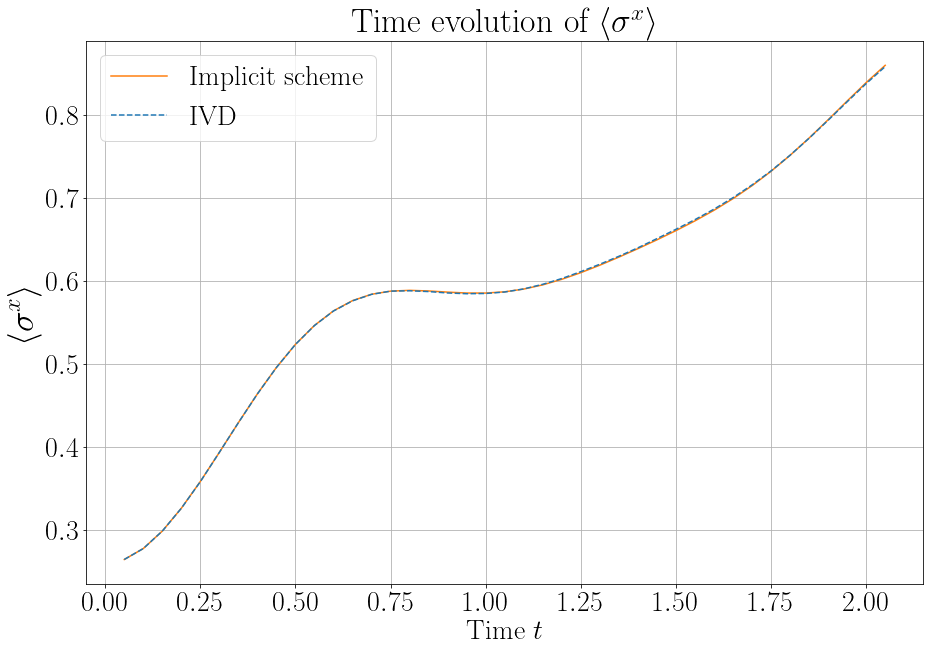

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.errorbar(t+dt, expval_xcorr_sampling, label = 'IVD', linestyle = 'dashed')
ax.plot(t+dt, expval_xcorr_implicit[1:], label = 'Implicit scheme')
ax.set_title(r"Time evolution of $\langle \sigma^x \rangle$")
ax.set_ylabel(r"$\langle \sigma^x \rangle$", fontsize = 35)
ax.set_xlabel("Time $t$")
ax.legend()
ax.grid()


## Expectation value through Netket VMC

In [21]:
expval_xcorr_sampling_vmc_mean = []
expval_xcorr_sampling_vmc_error_of_mean = []
expval_zzcorr_sampling_vmc_mean = []
expval_zzcorr_sampling_vmc_error_of_mean = []


energy_mean = []
energy_error_of_mean = []

hi = nk.hilbert.Spin(s=1 / 2, N=N)

for j in range(t.size):
    nkvstate = netket_model(params_sampling[j], Ns = 2016)

    xcorr_stat = nkvstate.expect(xcorr)
    zzcorr_stat = nkvstate.expect(zzcorr)
    energy_stat = nkvstate.expect(H_op)
    
    print(xcorr_stat)

    expval_xcorr_sampling_vmc_mean.append(xcorr_stat.mean.real)
    expval_xcorr_sampling_vmc_error_of_mean.append(xcorr_stat.error_of_mean)

    expval_zzcorr_sampling_vmc_mean.append(zzcorr_stat.mean.real)
    expval_zzcorr_sampling_vmc_error_of_mean.append(zzcorr_stat.error_of_mean)

    energy_mean.append(energy_stat.mean.real)
    energy_error_of_mean.append(energy_stat.error_of_mean)

0.2571+0.0000j ± 0.0100 [σ²=0.1300, R̂=1.0102]
0.2493+0.0025j ± 0.0092 [σ²=0.1102, R̂=1.0091]
0.303-0.009j ± 0.011 [σ²=0.148, R̂=1.0123]
0.2883+0.0044j ± 0.0093 [σ²=0.1087, R̂=1.0102]
0.3193+0.0038j ± 0.0092 [σ²=0.1091, R̂=1.0111]
0.3554+0.0015j ± 0.0092 [σ²=0.1092, R̂=1.0143]
0.4044-0.0064j ± 0.0094 [σ²=0.1146, R̂=1.0082]
0.4285-0.0018j ± 0.0088 [σ²=0.1012, R̂=1.0087]
0.4669-0.0018j ± 0.0084 [σ²=0.0950, R̂=1.0117]
0.4932+0.0026j ± 0.0083 [σ²=0.0941, R̂=1.0163]
0.5103+0.0056j ± 0.0079 [σ²=0.0837, R̂=1.0162]
0.5347+0.0017j ± 0.0076 [σ²=0.0813, R̂=1.0098]
0.5654-0.0042j ± 0.0082 [σ²=0.0915, R̂=1.0147]
0.5767-0.0072j ± 0.0081 [σ²=0.0934, R̂=1.0126]
0.5860+0.0002j ± 0.0086 [σ²=0.0996, R̂=1.0082]
0.5862+0.0018j ± 0.0086 [σ²=0.1012, R̂=1.0077]
0.5818-0.0002j ± 0.0087 [σ²=0.1086, R̂=1.0158]
0.5940-0.0022j ± 0.0091 [σ²=0.1164, R̂=1.0102]
0.5699+0.0019j ± 0.0092 [σ²=0.1155, R̂=1.0198]
0.5920+0.0032j ± 0.0096 [σ²=0.1259, R̂=1.0144]
0.589-0.002j ± 0.010 [σ²=0.133, R̂=1.0199]
0.567+0.002j ± 0.010 

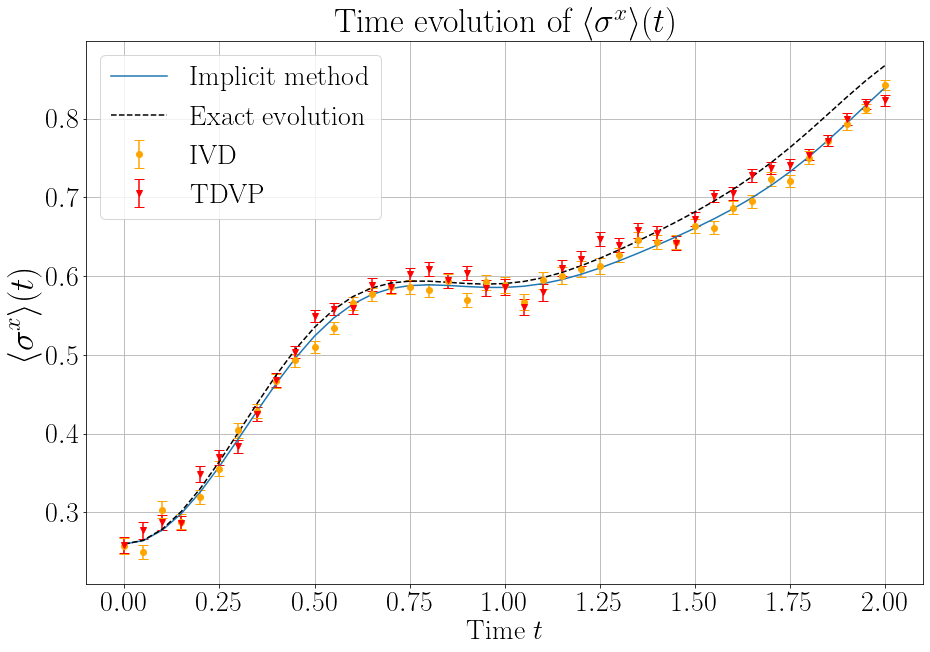

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.errorbar(t, expval_xcorr_sampling_vmc_mean, expval_xcorr_sampling_vmc_error_of_mean, color = 'orange', fmt='o', capsize=5,
            label = 'IVD')
ax.errorbar(t, expval_xcorr_TDVP_mean, expval_xcorr_TDVP_error_of_mean, color = 'red', fmt='v', capsize=5,
            label = 'TDVP')
ax.plot(t, expval_xcorr_implicit[:-1], label = 'Implicit method')
ax.plot(t, expval_xcorr_exact[:-1], color = 'black', linestyle = 'dashed', label = 'Exact evolution')

ax.set_title(r"Time evolution of $\langle \sigma^x \rangle (t)$")
ax.set_ylabel(r"$\langle \sigma^x \rangle (t)$", fontsize = 35)
ax.set_xlabel("Time $t$")
ax.legend()
ax.grid()
fig.savefig("time_evolution_sigmax.jpeg")


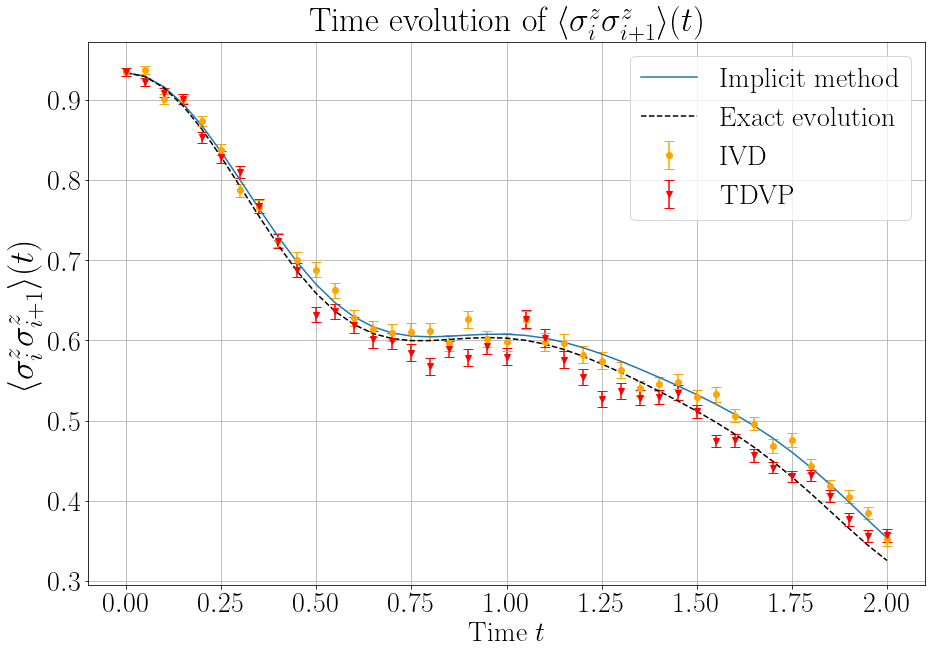

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.errorbar(t, expval_zzcorr_sampling_vmc_mean, expval_zzcorr_sampling_vmc_error_of_mean, color = 'orange', fmt='o', capsize=5,
            label = 'IVD')
ax.errorbar(t, expval_zzcorr_TDVP_mean, expval_zzcorr_TDVP_error_of_mean, color = 'red', fmt='v', capsize=5,
            label = 'TDVP')
ax.plot(t, expval_zzcorr_implicit[:-1], label = 'Implicit method')
ax.plot(t, expval_zzcorr_exact[:-1], color = 'black', linestyle = 'dashed', label = 'Exact evolution')

ax.set_title(r"Time evolution of $\langle \sigma^{z}_{i} \sigma^{z}_{i+1} \rangle (t)$")
ax.set_ylabel(r"$\langle \sigma^{z}_{i} \sigma^{z}_{i+1} \rangle (t)$", fontsize = 35)
ax.set_xlabel("Time $t$")
ax.legend()
ax.grid()
fig.savefig("time_evolution_sigmazz.jpeg")


## Checking the accordance

In [24]:
accordance_IVD_implicit = jnp.sum(jnp.abs(expval_xcorr_sampling_vmc_mean - expval_xcorr_implicit[:-1]) < jnp.array(expval_xcorr_sampling_vmc_error_of_mean))/len(expval_xcorr_sampling_vmc_mean)
print("Accordance IVD and implicit method:", accordance_IVD_implicit*100, " %")
print("\n")

accordance_IVD_TDVP = jnp.sum(jnp.abs(expval_xcorr_sampling_vmc_mean - expval_xcorr_TDVP_mean) < jnp.array(expval_xcorr_sampling_vmc_error_of_mean + expval_xcorr_TDVP_error_of_mean))/len(expval_xcorr_sampling_vmc_mean)
print("Accordance IVD and TDVP:", accordance_IVD_TDVP*100, " %")
print("\n")

accordance_IVD_exact = jnp.sum(jnp.abs(expval_xcorr_sampling_vmc_mean - expval_xcorr_exact[:-1]) < jnp.array(expval_xcorr_sampling_vmc_error_of_mean))/len(expval_xcorr_sampling_vmc_mean)
print("Accordance IVD and exact evolution:", accordance_IVD_exact*100, " %")
print("\n")

accordance_TDVP_exact = jnp.sum(jnp.abs(expval_xcorr_TDVP_mean - expval_xcorr_exact[:-1]) < jnp.array(expval_xcorr_TDVP_error_of_mean))/len(expval_xcorr_TDVP_mean)
print("Accordance TDVP and exact evolution:", accordance_TDVP_exact*100, " %")
print("\n")

Accordance IVD and implicit method: 73.17073170731707  %


Accordance IVD and TDVP: 68.29268292682927  %


Accordance IVD and exact evolution: 31.70731707317073  %


Accordance TDVP and exact evolution: 46.34146341463415  %




In [25]:
accordance_IVD_implicit = jnp.sum(jnp.abs(expval_zzcorr_sampling_vmc_mean - expval_zzcorr_implicit[:-1]) < jnp.array(expval_zzcorr_sampling_vmc_error_of_mean))/len(expval_zzcorr_sampling_vmc_mean)
print("Accordance IVD and implicit method:", accordance_IVD_implicit*100, " %")
print("\n")

accordance_IVD_TDVP = jnp.sum(jnp.abs(expval_zzcorr_sampling_vmc_mean - expval_zzcorr_TDVP_mean) < jnp.array(expval_zzcorr_sampling_vmc_error_of_mean + expval_zzcorr_TDVP_error_of_mean))/len(expval_zzcorr_sampling_vmc_mean)
print("Accordance IVD and TDVP:", accordance_IVD_TDVP*100, " %")
print("\n")

accordance_IVD_exact = jnp.sum(jnp.abs(expval_zzcorr_sampling_vmc_mean - expval_zzcorr_exact[:-1]) < jnp.array(expval_zzcorr_sampling_vmc_error_of_mean))/len(expval_zzcorr_sampling_vmc_mean)
print("Accordance IVD and exact evolution:", accordance_IVD_exact*100, " %")
print("\n")

accordance_TDVP_exact = jnp.sum(jnp.abs(expval_zzcorr_TDVP_mean - expval_zzcorr_exact[:-1]) < jnp.array(expval_zzcorr_TDVP_error_of_mean))/len(expval_zzcorr_TDVP_mean)
print("Accordance TDVP and exact evolution:", accordance_TDVP_exact*100, " %")
print("\n")

Accordance IVD and implicit method: 65.85365853658537  %


Accordance IVD and TDVP: 53.65853658536586  %


Accordance IVD and exact evolution: 39.02439024390244  %


Accordance TDVP and exact evolution: 34.146341463414636  %




## Number of iterations

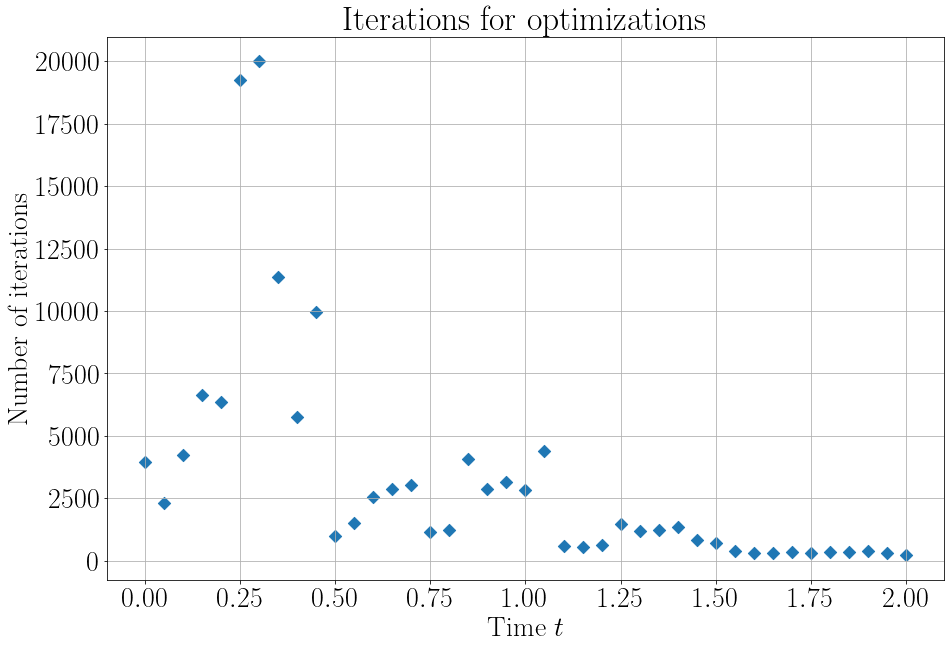

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.scatter(t, n_iterations_sampling, s= 75, marker = 'D')
ax.set_title("Iterations for optimizations")
ax.set_ylabel(r"Number of iterations")
ax.set_xlabel(r"Time $t$")
ax.grid()
fig.savefig("number_of_iterations.jpeg")


## Initial and final fidelity

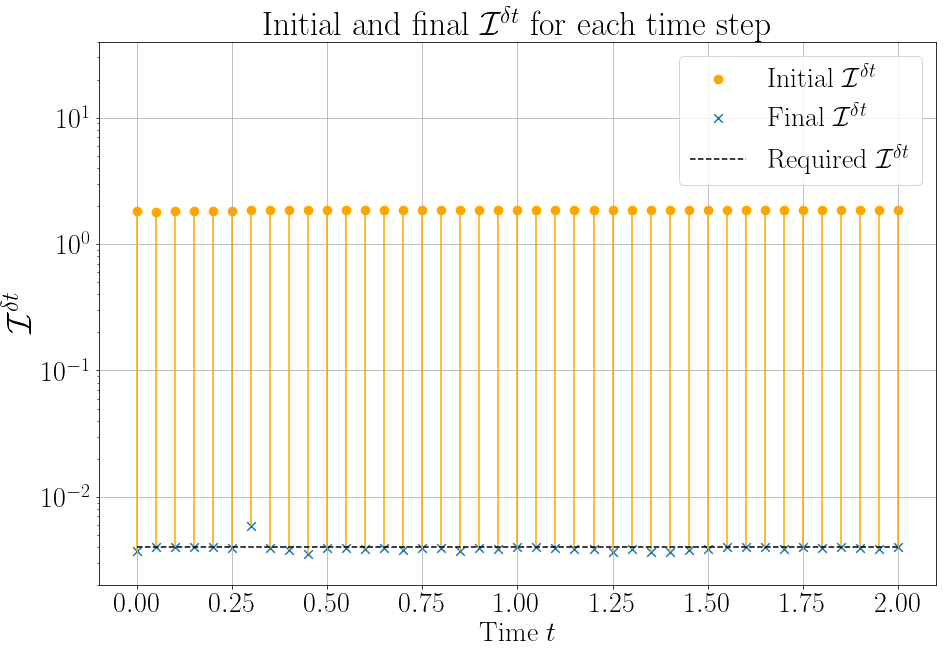

In [25]:
infidelity_initial_sampling = 1-np.array(fidelity_initial_sampling)
infidelity_final_sampling = 1- np.array(fidelity_final_sampling)

lines = []
for i in range(len(t)):
    pair=[(t[i], infidelity_initial_sampling[i]/dt**2), (t[i], infidelity_final_sampling[i]/dt**2)]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines, color = 'orange')
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

ax.add_collection(linecoll)
ax.scatter(t, infidelity_initial_sampling/dt**2, s= 75, marker = 'o', color = 'orange', label = "Initial $\mathcal{I}^{\delta t}$")
ax.scatter(t, infidelity_final_sampling/dt**2, s= 75, marker = 'x', label = "Final $\mathcal{I}^{\delta t}$")
ax.hlines(1e-5/dt**2, 0, np.max(t), linestyle = '--',  color = 'black', label = "Required $\mathcal{I}^{\delta t}$")
ax.set_title("Initial and final $\mathcal{I}^{\delta t}$ for each time step")
ax.set_ylabel(r"$\mathcal{I}^{\delta t}$", fontsize = 35)
ax.set_xlabel("Time $t$")
ax.legend()
ax.grid()
ax.set_yscale('log')
ax.set_ylim([0.5e-5/dt**2, 1e-1/dt**2])

fig.savefig("initial_final_step-infidelity.jpeg")


## Fidelity wrt to implicit evolution

In [26]:
import matplotlib.ticker as ticker

In [52]:
infidelity_wrt_implicit_sampling = jnp.concatenate((jnp.array([0]), 1-jnp.array(fidelity_wrt_implicit_sampling)))

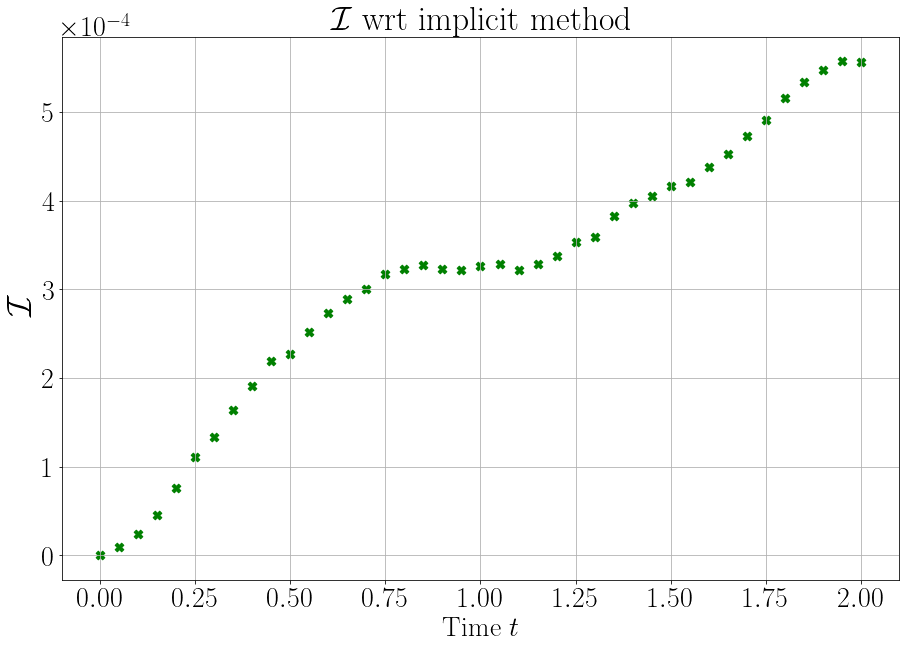

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.scatter(t, infidelity_wrt_implicit_sampling[:-1], s= 75, marker = 'X', color = 'green')
ax.set_title(r"$\mathcal{I}$ wrt implicit method")
ax.set_ylabel(r"$\mathcal{I}$", fontsize = 35)
ax.set_xlabel("Time $t$")
ax.grid()
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 
fig.savefig("infidelity_wrt_implicit.jpeg")



## Energy conservation

In [26]:
initial_energy = (psis_sampling[0].conj().T @ H_sparse @ psis_sampling[0])/(psis_sampling[0].conj().T @ psis_sampling[0])

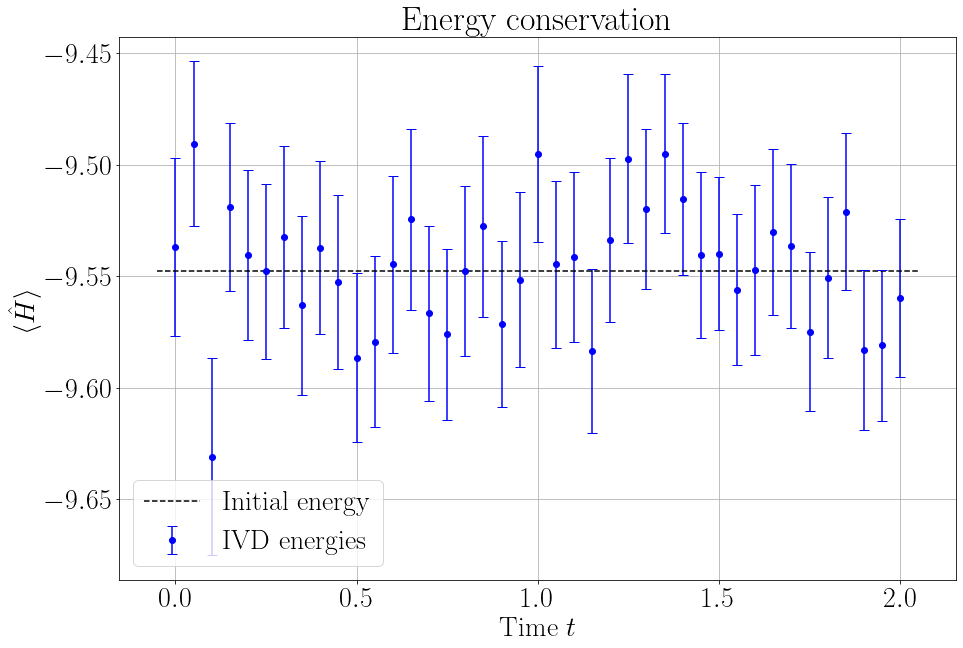

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.errorbar(t, energy_mean, energy_error_of_mean, color = 'blue', fmt='o', capsize=5,
            label = 'IVD energies')
ax.hlines(initial_energy.real, t[0]-dt, t[-1]+dt, color = 'black', linestyles='dashed', label = 'Initial energy')
ax.set_title(r"Energy conservation")
ax.set_ylabel(r"$\langle \hat{H}\rangle$")
ax.set_xlabel("Time $t$")
ax.legend(loc = "lower left")
ax.grid()
ax.plot
fig.savefig("energy_conservation.jpeg")


In [51]:
energy_conservation = jnp.sum(jnp.abs(jnp.array(energy_mean) - initial_energy) < jnp.array(energy_error_of_mean))/len(energy_mean)
print("Energy conservation via IVD:", energy_conservation*100, " %")

Energy conservation via IVD: 73.17073170731707  %


## State evolution

In [34]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

The minimum of the state at t = 0.00 is: 1.8880346314351355e-07
The minimum of the state at t = 0.05 is: 2.1104807666883133e-07
The minimum of the state at t = 0.10 is: 4.880237402270868e-07
The minimum of the state at t = 0.15 is: 1.3688615697718575e-06
The minimum of the state at t = 0.20 is: 2.7246109837522524e-06
The minimum of the state at t = 0.25 is: 4.8385235848916414e-06
The minimum of the state at t = 0.30 is: 7.002782417028535e-06
The minimum of the state at t = 0.35 is: 1.2419902906792512e-05
The minimum of the state at t = 0.40 is: 2.3875609207615697e-05
The minimum of the state at t = 0.45 is: 4.1078998616797045e-05
The minimum of the state at t = 0.50 is: 5.917879082929473e-05
The minimum of the state at t = 0.55 is: 7.226078101133493e-05
The minimum of the state at t = 0.60 is: 7.507753371930986e-05
The minimum of the state at t = 0.65 is: 6.797950280010948e-05
The minimum of the state at t = 0.70 is: 5.449164043307281e-05
The minimum of the state at t = 0.75 is: 3.7555

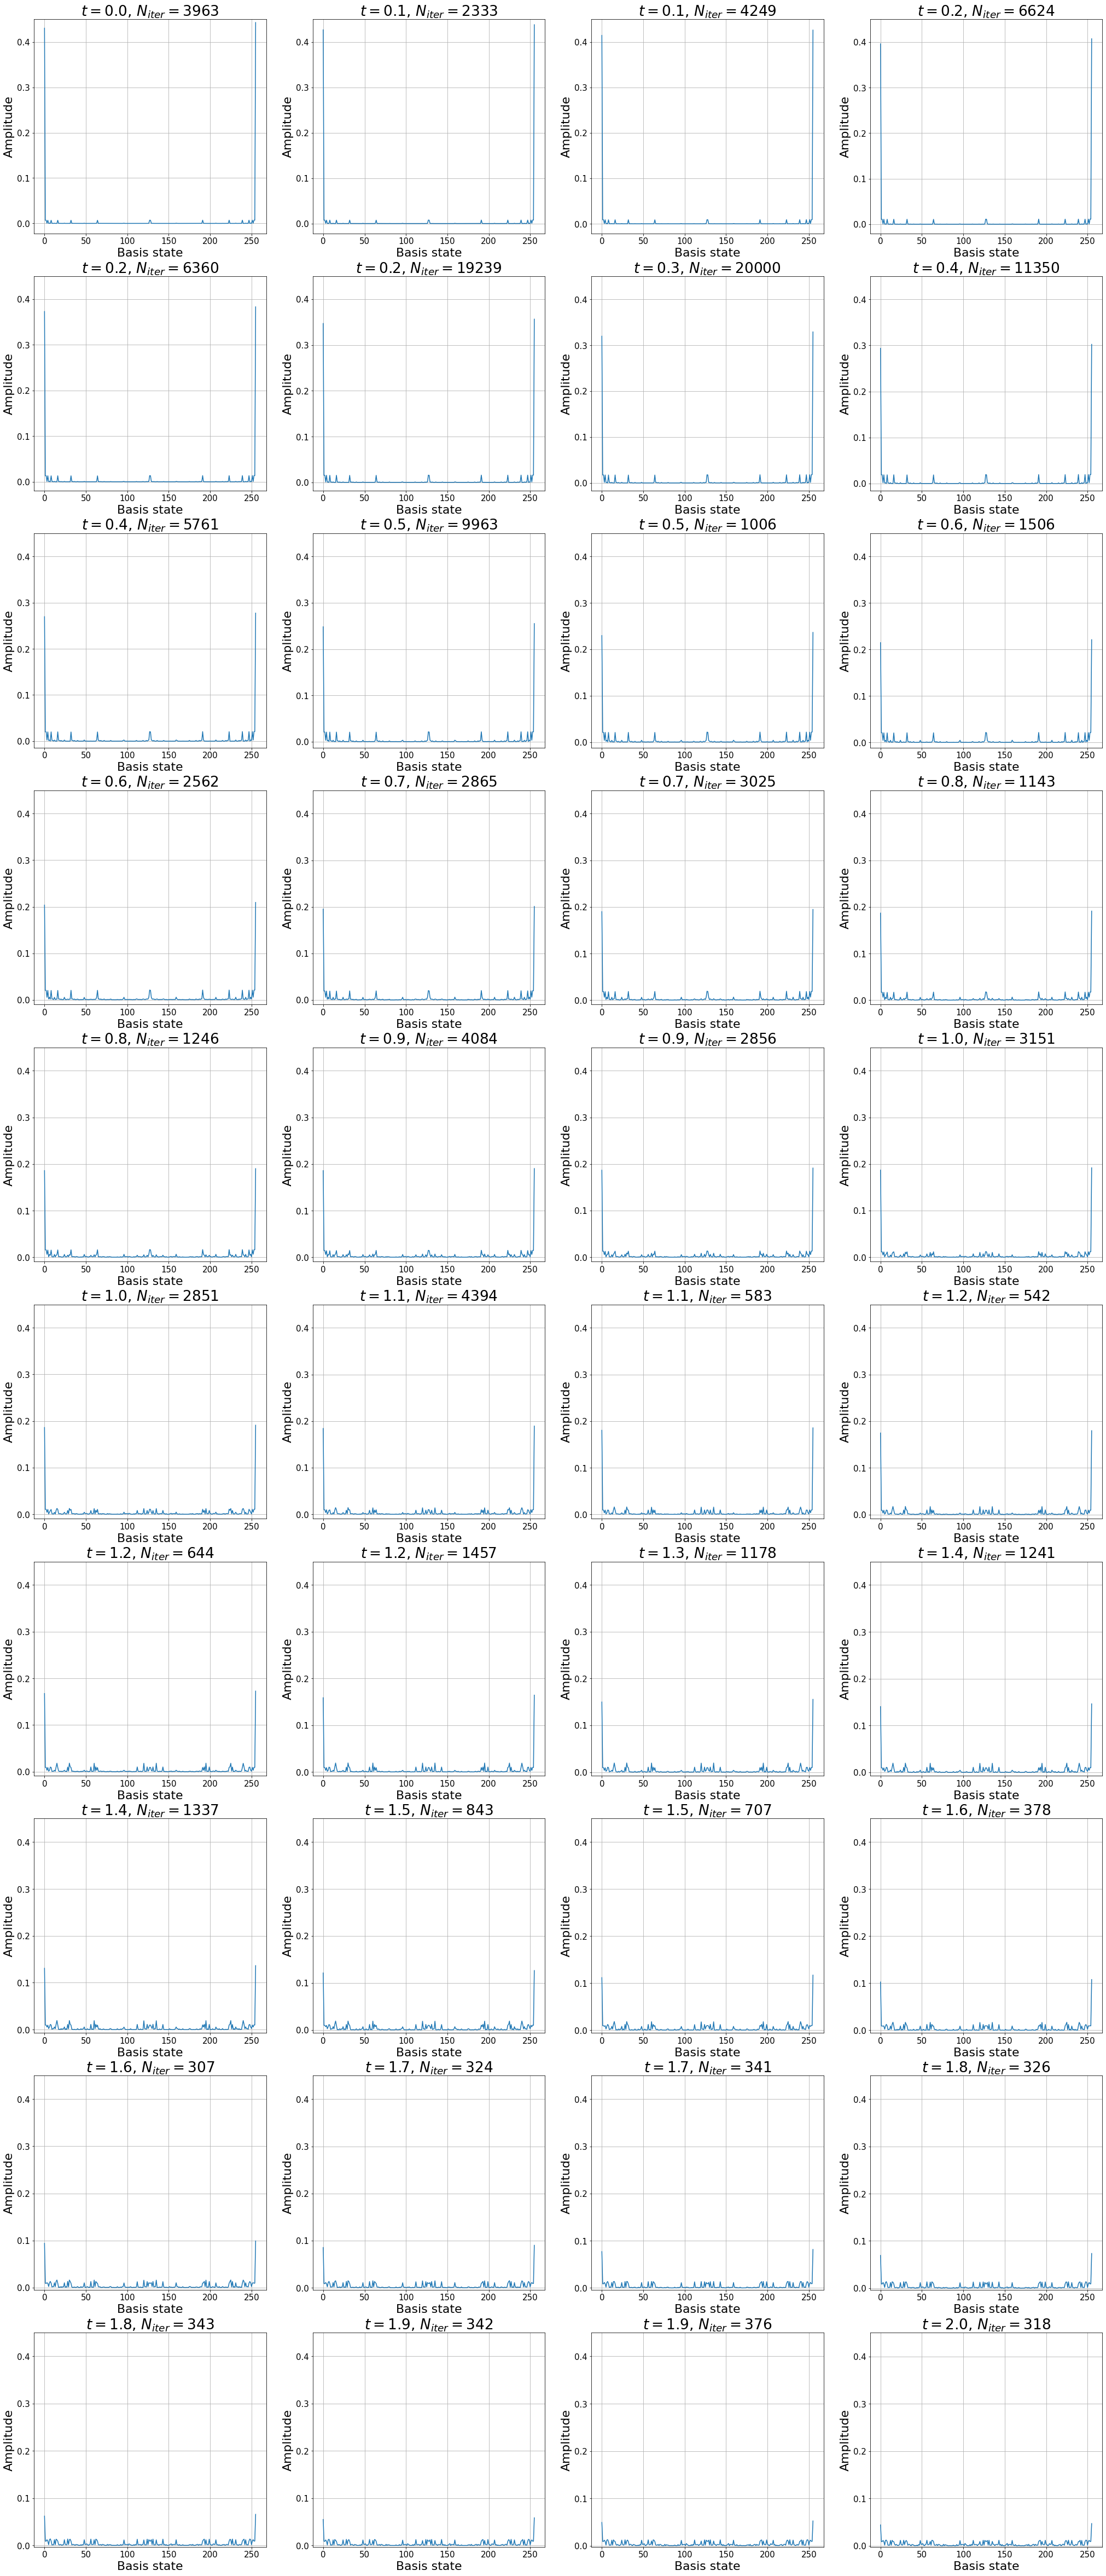

In [57]:
fig, axs = plt.subplots(10, 4)
fig.set_size_inches(35, 85)

for i in range(10):
    for j in range(4):
        state = psis_sampling[i*4+j]
        state /= jnp.linalg.norm(state)
        prob = jnp.square(jnp.absolute(state))
        axs[i, j].plot(prob)
        t_string = "%.1f" % t[i*4+j] 
        n_iter_string = "%i" % n_iterations_sampling[i*4+j]
        print("The minimum of the state at t = %.2f" % t[i*4+j] + " is:", jnp.min(prob))
        axs[i, j].set_title(r"$t = $" + t_string + ", $N_{iter} = $" + n_iter_string)
        axs[i, j].set_xticks([0, 50, 100, 150, 200, 250])
        axs[i, j].set_ylim(top = 0.45)
        axs[i, j].set_ylabel("Amplitude")
        axs[i, j].set_xlabel("Basis state")
        axs[i, j].grid()

fig.savefig("state_evolution.jpeg")